# <u>Stance Detection for Fake News</u>
The goal of the Fake News Challenge is to explore how AI/ML might be leveraged to combat the fake news problem. <br/>
Assessing the veracity of a news story is a complex and cumbersome task, even for trained experts. Fortunately, the process can be broken down into steps or stages. A helpful first step towards identifying fake news is to understand what other news organizations are saying about the topic. We believe automating this process, called **Stance Detection**, could serve as a useful building block in an AI-assisted fact-checking pipeline.<br/>
Stance Detection involves estimating the relative perspective (or stance) of two pieces of text relative to a topic, claim or issue. This extends the [work](https://www.aclweb.org/anthology/N16-1138/) of Ferreira & Vlachos. The task is to estimate the stance of a body text from a news article relative to a headline. Specifically, the body text may agree, disagree, discuss or be unrelated to the headline.
### Project Description
Given the huge impact of social networks, online content plays an important role in forming or changing the opinions of people. Online journalism has given chance even for individuals to publish leading to individual empowerment but has given a chance to a lot of malicious entities to spread misinformation for their own benefit. But this has an influence on major events like the outcome of elections. Therefore, it is of great importance now, to have some sort of automated classification of news stories.

In this work, we will implement different deep neural architectures using word embeddings for identifying the stance detection of different news stories.
### Dataset
The dataset is taken from Fake News Challenge, where the goal of the challenge is not to directly identify whether a headline or article is “fake” or not, which is arguably a highly subjective question, and one that even skilled humans may have difficulty answering.
The challenge is organized around the more well-defined problem of “stance detection,” which involves comparing a headline with a body of text from a news article to determine what relationship (if any) exists between the two.
There are 4 possible classifications:
1. **Agree**- The article text agrees with the headline.
2. **Disagree**- The article text disagrees with the headline.
3. **Discussion**- The article text is a discussion of the headline, without taking a position on it.
4. **Unrelated**- The article text is unrelated to the headline (i.e. it doesn’t address the same topic).

Check the problem context [here](https://drive.google.com/open?id=1KfWaZyQdGBw8AUTacJ2yY86Yxgw2Xwq0).

Download files required for the project from [here](https://drive.google.com/open?id=10yf39ifEwVihw4xeJJR60oeFBY30Y5J8).

### Goal of the project
1. Convert words into vectors and make them ready for the model.
2. Build a Sequential Models like RNN, LSTM..
3. Train the model and report the accuracy score.
4. Add checkpoints as callbacks to the model and save the model for each epoch.
5. (Optional) Add attention to the above model and report the change in accuracy. And explain how and why attention has improved (or disturbed) the model.
---

## Imports and Configurations

In [2]:
conda install keras, tensorflow

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - keras,

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [1]:
# Utilities
import os, zipfile, sys, warnings
from time import time

# Numerical calculation
import numpy as np

# Data Handling
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sequential Modeling
import keras.backend as K
from keras import initializers
from keras.engine.topology import Layer, InputSpec
from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Conv1D, MaxPooling1D
from keras.layers import Embedding, Activation, Dropout, Flatten, Bidirectional
from keras.layers import Permute, merge, Input, multiply, concatenate
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.constraints import max_norm, unit_norm

# Preprocessing and NLP library
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
import nltk

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_recall_curve

ModuleNotFoundError: No module named 'keras'

In [0]:
# Configure for any default setting of any library
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

### Set the working directory
Mount the drive and set the project path to cureent working directory, when running in Google Colab. No changes are required in case of running in Local PC.

In [3]:
# Block which runs on both Google Colab and Local PC without any modification
if 'google.colab' in sys.modules:    
    project_path = "/content/drive/My Drive/Colab Notebooks/DLCP/FakeNewsDetection-NLP/"
    # Google Colab lib
    from google.colab import drive
    # Mount the drive
    drive.mount('/content/drive/', force_remount=True)
    sys.path.append(project_path)
    %cd $project_path

# Let's look at the sys path
print('Current working directory', os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/DLCP/FakeNewsDetection-NLP
Current working directory /content/drive/My Drive/Colab Notebooks/DLCP/FakeNewsDetection-NLP


---
## Step1: Loading the data
- Extract Glove 6Billion word embeddings. We're going to use the 100d file which has 100 embedding dimensions for each word in the corpus.
- Load the bodies and headlines CSVs for both training and test data and join them together individually to form datasets.

### Extract the Glove Embeddings

In [0]:
# Open the zipped file as readonly
glove_embeddings = 'glove.6B.zip'
with zipfile.ZipFile(glove_embeddings, 'r') as archive:
    archive.extractall('glove.6B')

### Load the training dataset
1. Using [read_csv()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) in pandas load the given train datasets files **`train_bodies.csv`** and **`train_stances.csv`**

2. Using [merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) command in pandas merge the two datasets based on the Body ID. 

Note: Save the final merged dataset in a dataframe with name **`dataset`**.

In [0]:
# Load the news bodies and stances csvs
train_bodies = pd.read_csv('train_bodies.csv')
train_stances = pd.read_csv('train_stances.csv')

In [0]:
# Merge both the dataset to form a single dataset
dataset = pd.merge(train_bodies[['Body ID', 'articleBody']],
                   train_stances[['Body ID', 'Headline', 'Stance']], 
                   left_on='Body ID', 
                   right_on='Body ID', 
                   how='inner')

### Check1:
You should see the below output if you run `dataset.head()` command as given below

In [7]:
dataset.head()

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated


In [8]:
# Find unique train articles
print('There are \033[1m%d\033[0m unique articles present in \033[1m%d Train Data\033[0m' % 
      (dataset['Body ID'].nunique(), dataset.shape[0]))

There are 1683 unique articles present in 49972 Train Data


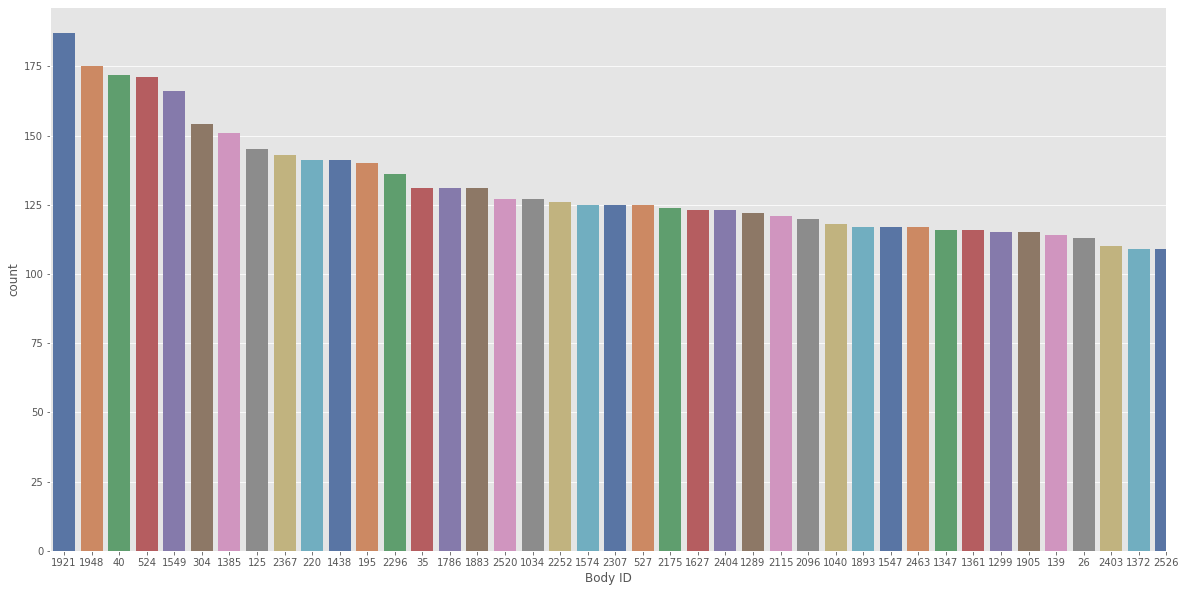

In [9]:
# Visualize top 40 articles having most different headlines in train data
plt.figure(figsize=(20,10))
g = sns.countplot(train_stances['Body ID'], order=train_stances['Body ID'].value_counts().index,palette="deep")
_ = g.set(xlim=(None, 40))

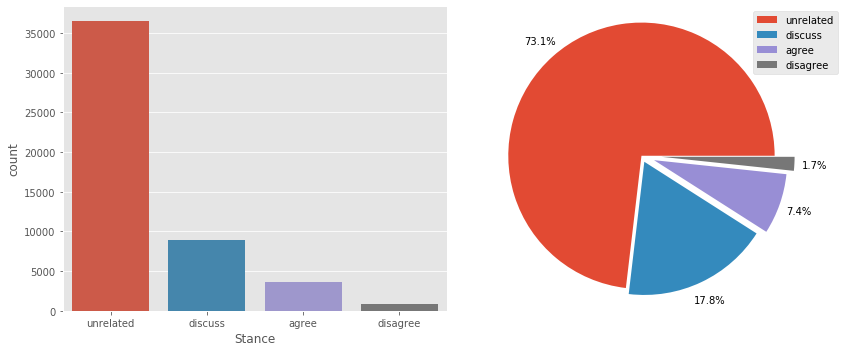

In [10]:
# Analyze the unique stances and their volume
# stances, counts = np.unique(train_stances['Stance'], return_counts=True)
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.countplot(train_stances['Stance'], order=train_stances['Stance'].value_counts().index, ax=axes[0])
explode = (0,0.05,0.1,0.15)
_ = axes[1].pie(train_stances['Stance'].value_counts(), autopct='%1.1f%%', explode=explode, pctdistance=1.15)
axes[1].legend(labels=train_stances['Stance'].value_counts().index,loc="best")
axes[1].axis('equal')
plt.tight_layout()

### Load test data
1. Using [read_csv()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) in pandas load the given test datasets files **`test_bodies.csv`** and **`test_stances.csv`**

2. Using [merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) command in pandas merge the two datasets based on the Body ID. 

Note: Save the final merged dataset in a dataframe with name **`test_dataset`**.

In [0]:
# Load the news bodies and stances csvs
test_bodies = pd.read_csv('test_bodies.csv')
test_stances = pd.read_csv('test_stances_unlabeled.csv')

In [0]:
# Merge both the dataset to form a single dataset
test_dataset = pd.merge(test_bodies[['Body ID', 'articleBody']],
                   test_stances[['Body ID', 'Headline']], 
                   left_on='Body ID', 
                   right_on='Body ID', 
                   how='inner')

In [13]:
# Find unique test articles
print('There are \033[1m%d\033[0m unique articles present in \033[1m%d Test Data\033[0m' % 
      (test_dataset['Body ID'].nunique(), test_dataset.shape[0]))

There are 904 unique articles present in 25413 Test Data


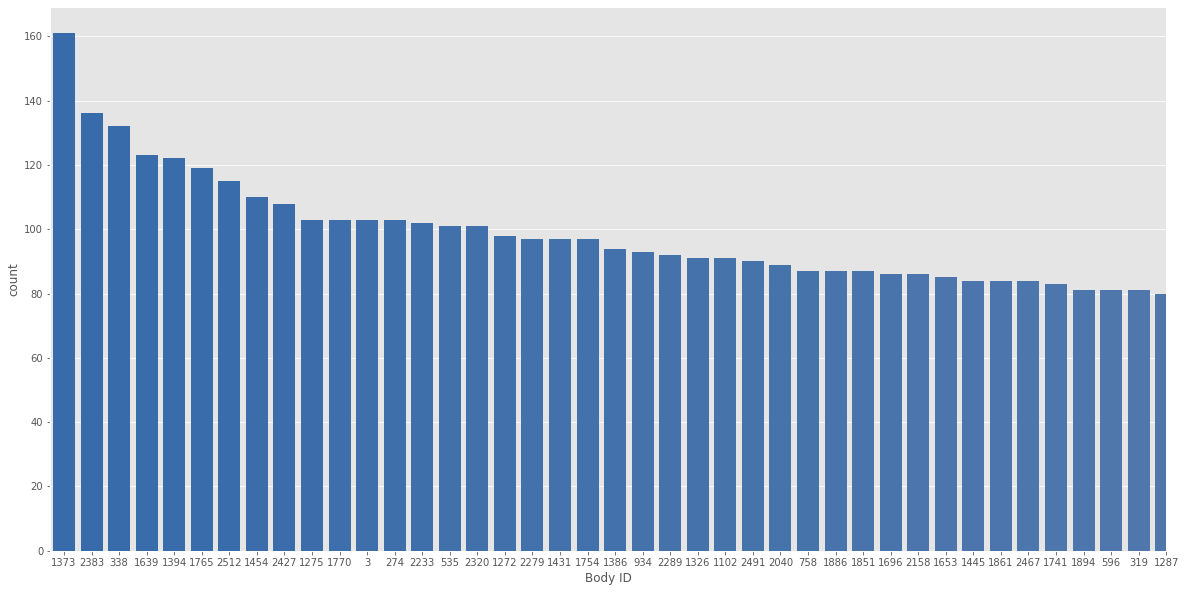

In [14]:
# Visualize top 40 articles having most different headlines in test data
plt.figure(figsize=(20,10))
g = sns.countplot(test_stances['Body ID'], order=test_stances['Body ID'].value_counts().index,palette="vlag")
_ = g.set(xlim=(None, 40))

**Observations:**
- The whole dataset (training and testing) is collected for $1683+904=2587$ unique articles spread over $49972+25413=75385$ different headlines altogether.
- Training data consists of huge amount of "unrelated" stances which indicates publication platforms use their own creativity to form the headline for a single article, based on how catchy they can make it to sell the news.
- Body ID "1921", "1948", "1373", "2383" etc. are some of the top/more popular articles in the entire dataset to have huge variations in their headlines across all publication platforms.
---

## Step2: Data Pre-processing and setting some hyper parameters needed for model


#### Run the code given below to set the required parameters.

1. `MAX_SENTS` = Maximum no.of sentences to consider in an article.

2. `MAX_SENT_LENGTH` = Maximum no.of words to consider in a sentence.

3. `MAX_NB_WORDS` = Maximum no.of words in the total vocabualry.

4. `MAX_SENTS_HEADING` = Maximum no.of sentences to consider in a heading of an article.


In [0]:
MAX_NB_WORDS = 20000
MAX_SENTS = 20
MAX_SENTS_HEADING = 1
MAX_SENT_LENGTH = 20
VALIDATION_SPLIT = 0.2

### Download the `Punkt` from nltk using the commands given below. This is for sentence tokenization.

For more info on how to use it, read [this](https://stackoverflow.com/questions/35275001/use-of-punktsentencetokenizer-in-nltk).

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Tokenizing the text and loading the pre-trained Glove word embeddings for each token
Keras provides [Tokenizer API](https://keras.io/preprocessing/text/) for preparing text. Read it before going any further.
#### Initialize the Keras Tokenizer class with maximum vocabulary count as `MAX_NB_WORDS` initialized at the start of step2. 

In [0]:
t = Tokenizer(num_words=MAX_NB_WORDS,filters= '!"#$%&()*+,-./:;<=>?@[\]^_`{|}\n“~”')

#### Now, using fit_on_texts() from Tokenizer class, lets encode the data 

Note: We need to fit articleBody and Headline also to cover all the words.

In [0]:
# t.fit_on_texts(dataset['articleBody'])
# t.fit_on_texts(dataset['Headline'])
t.fit_on_texts(dataset['articleBody'].append(dataset['Headline'], ignore_index=True))

#### fit_on_texts() gives the following attributes in the output as given [here](https://faroit.github.io/keras-docs/1.2.2/preprocessing/text/).

* **word_counts:** dictionary mapping words (str) to the number of times they appeared on during fit. Only set after fit_on_texts was called.

* **word_docs:** dictionary mapping words (str) to the number of documents/texts they appeared on during fit. Only set after fit_on_texts was called.

* **word_index:** dictionary mapping words (str) to their rank/index (int). Only set after fit_on_texts was called.

* **document_count:** int. Number of documents (texts/sequences) the tokenizer was trained on. Only set after fit_on_texts or fit_on_sequences was called.



In [19]:
vocab_size = len(t.word_index) + 1
print('Vocabulary size: %d\nDocuments count: %d' % (vocab_size, t.document_count))

Vocabulary size: 26532
Documents count: 99944


**Note:**
- That `+ 1` is because of reserving padding (i.e. index zero).

### Now, tokenize the sentences using nltk sent_tokenize() and encode the sentences with the ids we got form the above `t.word_index`

Initialise 2 lists with names `texts` and `articles`.
```
texts = [] to store text of article as it is.
articles = [] split the above text into a list of sentences.
```

In [0]:
texts = [] ## body
articles=[] ## body splitted into senteces and stored as a list of lists

## split into sentences
for text in dataset['articleBody']:
    texts.append(text)
    sentences = nltk.tokenize.sent_tokenize(text)
    articles.append(sentences)

### Check 2:
first element of texts and articles should be as given below. 

In [21]:
texts[0]

'A small meteorite crashed into a wooded area in Nicaragua\'s capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city\'s airport, the Associated Press reports. \n\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth." House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\n\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\n\nHumbe

In [22]:
articles[0]

["A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday.",
 "Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports.",
 'Government spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth."',
 'House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports.',
 'Murillo said Nicaragua will ask international experts to help local scientists in understanding what happened.',
 'The crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee.',
 'He said it is still not clear if the meteorite disintegrated or was bu

### Now iterate through each article and each sentence to encode the words into ids using t.word_index

Here, to get words from sentence you can use `text_to_word_sequence` from keras preprocessing text.

1. Import text_to_word_sequence

2. Initialize a variable of shape (no.of articles, MAX_SENTS, MAX_SENT_LENGTH) with name `data` with zeros first (you can use numpy [np.zeros](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html) to initialize with all zeros)and then update it while iterating through the words and sentences in each article.

In [0]:
## for article body
data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
## word index encoding
for i, sentences in enumerate(articles):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for word in wordTokens:
                try:
                    if k < MAX_SENT_LENGTH and t.word_index[word] < MAX_NB_WORDS:
                        data[i, j, k] = t.word_index[word]
                        k = k + 1
                except:
                        pass

### Check 3:

Accessing first element in data should give something like given below.

In [24]:
data[0, :, :]

array([[    3,   473,   424,  7162,    80,     3,  3725,   333,     5,
         3875,   352,     4,  1432,  2953,     1,    88,    12,   464,
            0,     0],
       [  759,    95,  1048,     3,  2679,  1751,     7,   189,     3,
         1219,  1058,  1971,   701,   160,     1,  3026,   448,     1,
          552,   234],
       [   88,  1069,  4099,  2346,    12,     3,  1092,  3303,    19,
            1,    88,     2,  1791,     1,   514,  2012,    15,     9,
            3,  2917],
       [  185,  3633,   974,   199,  2511,    43,  6734,  1722,  1254,
            5, 12997, 17318,     1,   754,    29,   742,  3979,    65,
           85,     0],
       [ 2346,    12,  1557,    37,  1098,   354,   775,     2,   361,
          262,  1768,     5,  4447,    68,   493,     0,     0,     0,
            0,     0],
       [    1,   701,   189,    19,     1,   424,    31,     3,  7360,
            4,  2154,  1254,     6,     3,  5235,     4,  1219,  1254,
           12,  3363],
       [  

### Repeat the same process for the `Headings` as well. Use variables with names `texts_heading` and `articles_heading` accordingly.

In [0]:
texts_heading = [] ## body
articles_heading = [] ## body splitted into senteces and stored as a list of lists

## split into sentences
for text in dataset['Headline']:
    texts_heading.append(text)
    sentences = nltk.tokenize.sent_tokenize(text)
    articles_heading.append(sentences)

## for article headings
data_heading = np.zeros((len(texts_heading), MAX_SENTS_HEADING, MAX_SENT_LENGTH), dtype='int32')
## word index encoding
for i, sentences in enumerate(articles_heading):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS_HEADING:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                try:
                    if k < MAX_SENT_LENGTH and t.word_index[word] < MAX_NB_WORDS:
                        data_heading[i, j, k] = t.word_index[word]
                        k = k + 1
                except:
                    pass

### Now the features are ready, lets make the labels ready for the model to process.

### Convert labels into one-hot vectors

You can use [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) in pandas to create one-hot vectors.

In [0]:
## one-hot vectors for labels                  
labels = dataset['Stance']
targets = pd.Series(labels)
one_hot = pd.get_dummies(targets, sparse = True)
one_hot_labels = np.asarray(one_hot)
labels = one_hot_labels

### Check 4:

The shape of data and labels shoould match the given below numbers.

In [27]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (49972, 20, 20)
Shape of label tensor: (49972, 4)


### Shuffle the data

In [0]:
## get numbers upto no.of articles
indices = np.arange(data.shape[0])
## shuffle the numbers
np.random.shuffle(indices)

In [0]:
## shuffle the data
data = data[indices]
data_heading = data_heading[indices]
## shuffle the labels according to data
labels = labels[indices]

### Split into train and validation sets. Split the train set 80:20 ratio to get the train and validation sets.


Use the variable names as given below:

x_train, x_val - for body of articles.

x_heading_train, x_heading_val - for heading of articles.

y_train - for training labels.

y_val - for validation labels.



In [0]:
## no.of validation samples = 0.2 of original size
nb_validation_samples = int(data.shape[0] * VALIDATION_SPLIT)

In [0]:
## for train and validation samples
x_train = data[:-nb_validation_samples]
x_heading_train = data_heading[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
x_heading_val = data_heading[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

### Check 5:

The shape of x_train, x_val, y_train and y_val should match the below numbers.

In [32]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(39978, 20, 20)
(39978, 4)
(9994, 20, 20)
(9994, 4)


### Create embedding matrix with the glove embeddings


Run the below code to create embedding_matrix which has all the words and their glove embedding if present in glove word list.

In [33]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))


for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


---
## Step 3: Try the sequential model approach and report the accuracy score.  

#### Generic Methods for Accuracy
Let's write some generic method to plot some useful curves such as validation curves, precision-recall curves and print the classification summary.

In [0]:
# Generic method to plot the VALIDATION curves
def plot_validation_curve(history, metrics):
    plt.clf()
    history_dict = history.history
    f, ax = plt.subplots(1, len(metrics), figsize=(16,6))
    for i, metric in enumerate(metrics):
        metric_values = history_dict[metric]
        val_metric_values = history_dict['val_' + metric]
        epochs = range(1, (len(history_dict[metric]) + 1))
        ax[i].plot(epochs, metric_values, 'bo:', label='Training ' + metric)
        ax[i].plot(epochs, val_metric_values, 'go-', label='Validation ' + metric)
        ax[i].set_title('Training and Validation ' + ('Accuracy' if metric=='acc' else 'Loss'))
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Accuracy' if metric=='acc' else 'Loss')
        ax[i].legend()

In [0]:
# Generic method to print the classification report
def classification_summary(y_test, y_pred, y_proba):
    print('\033[1mModel accuracy:\033[0m %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('_'*80)
    print('\033[1mConfusion matrix:\033[0m\n %s' % (confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
    print('_'*80)
    print('\033[1mClassification report:\033[0m\n %s' % (classification_report(y_test, y_pred)))
    print('_'*80)

In [36]:
# Build the model
embedding_dim = 100

sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
print(sentence_input)
embedded_sequences = Embedding(output_dim=embedding_dim, 
                               input_dim=vocab_size, 
                               input_length=(MAX_SENT_LENGTH,), 
                               weights=[embedding_matrix])(sentence_input)

l_lstm = Bidirectional(LSTM(100, return_sequences=True,
                            dropout=0.4,
                            kernel_constraint=unit_norm(),
                            recurrent_constraint=unit_norm(),
                            bias_constraint=unit_norm()))(embedded_sequences)
l_dense = TimeDistributed(Dense(100))(l_lstm)
l_dropout = Dropout(0.4)(l_dense)
l_dense = Flatten()(l_dropout)
sentEncoder = Model(sentence_input, l_dense)

body_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH,), dtype='int32')
print(body_input)
body_encoder = TimeDistributed(sentEncoder)(body_input)
print(body_encoder)
l_lstm_sent = Bidirectional(LSTM(100, return_sequences=True,
                            dropout=0.4,
                            kernel_constraint=unit_norm(),
                            recurrent_constraint=unit_norm(),
                            bias_constraint=unit_norm()))(body_encoder)
l_dense_sent = TimeDistributed(Dense(100))(l_lstm_sent)
l_dropout_sent = Dropout(0.4)(l_dense_sent)
l_dense_sent = Flatten()(l_dropout_sent)


heading_input = Input(shape=(MAX_SENTS_HEADING, MAX_SENT_LENGTH,), dtype='int32')
heading_embedded_sequences = Embedding(output_dim=embedding_dim, 
                                       input_dim=vocab_size,
                                       input_length=(MAX_SENTS_HEADING, MAX_SENT_LENGTH,), 
                                       weights=[embedding_matrix])(heading_input)
h_dense = Dense(100, activation='relu')(heading_embedded_sequences)
h_flatten = Flatten()(h_dense)
article_output = concatenate([l_dense_sent, h_flatten], name='concatenate_heading')

news_vector = Dense(100, activation='relu')(article_output)
preds = Dense(4, activation='softmax')(news_vector)
model = Model([body_input, heading_input], [preds])



Tensor("input_1:0", shape=(?, 20), dtype=int32)








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("input_2:0", shape=(?, 20, 20), dtype=int32)
Tensor("time_distributed_2/Reshape_1:0", shape=(?, 20, 2000), dtype=float32)


In [37]:
# Print the summary of the model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 20)       0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 20, 2000)     2834100     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 20, 200)      1680800     time_distributed_2[0][0]         
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1, 20)        0                                            
____________________________________________________________________________________________

### Compile and fit the model
#### early_stopping and model_checkpoint layers.

In [38]:
#Path where you want to save the weights, model and checkpoints
model_path = "Weights/"
%mkdir Weights

mkdir: cannot create directory ‘Weights’: File exists


In [0]:
def call_backs(name):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=100)
    model_checkpoint =  ModelCheckpoint(model_path + name + '_epoch_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                               monitor='val_loss',
                                                               verbose=1,
                                                               save_best_only=True,
                                                               save_weights_only=False,
                                                               mode='min',
                                                               period=1)
    return [model_checkpoint, early_stopping]

In [40]:
st = time()
epochs = 10
batches = 50
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
print("Training Hierachical LSTM network")
history = model.fit([x_train, x_heading_train], [y_train], 
                    validation_data=([x_val, x_heading_val], [y_val]), 
                    callbacks=call_backs('stance.fake.news'), 
                    epochs=epochs, 
                    batch_size=batches)

print('Time taken to train the network: %.2f sec' % (time()-st))

# Save weights
model.save_weights(model_path + 'stance.fake.news_weights_epoch_{}.h5'.format(epochs))
print ("model and weight files saved at : " + os.path.join(os.getcwd(), model_path))



Training Hierachical LSTM network
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 39978 samples, validate on 9994 samples
Epoch 1/10
39978/39978 [==============================] - 132s 3ms/step - loss: 0.6538 - acc: 0.7634 - val_loss: 0.4781 - val_acc: 0.8219

Epoch 00001: val_loss improved from inf to 0.47814, saving model to Weights/stance.fake.news_epoch_01_loss0.4781.h5
Epoch 2/10
39978/39978 [==============================] - 128s 3ms/step - loss: 0.4193 - acc: 0.8390 - val_loss: 0.3687 - val_acc: 0.8554

Epoch 00002: val_loss improved from 0.47814 to 0.36869, saving model to Weights/stance.fake.news_epoch_02_loss0.3687.h5
Epoch 3/10
39978/39978 [==============================] - 129s 3ms/step - loss: 0.3140 - acc: 0.8803 - val_loss: 0.3040 - val_acc: 0.8849

Epoch 00003: val_loss improved from 0.36869 to 0.30401, saving model to Weights/stance.fake.news_epoch_03_loss0.3040.h5
Epoch 4/10
39978/39978 [======================

### Evaluate the model

<Figure size 432x288 with 0 Axes>

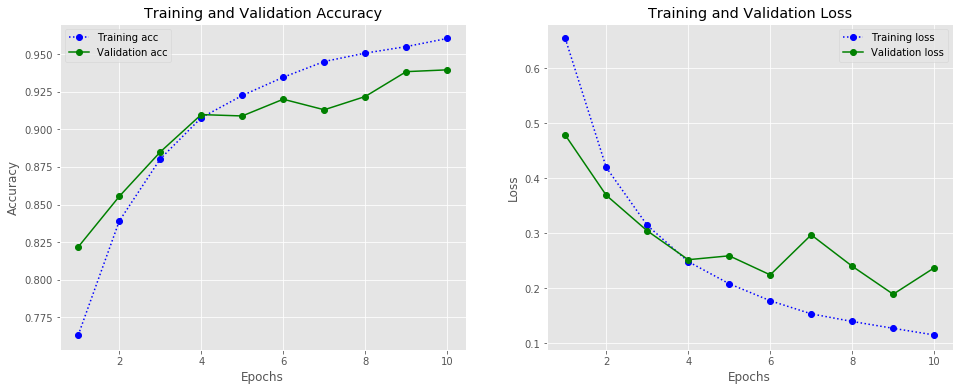

In [41]:
# VALIDATION ACCURACY and LOSS Curve
plot_validation_curve(history, ['acc','loss'])

In [42]:
loss, acc = model.evaluate([x_val, x_heading_val], y_val)
print('Accuracy:', np.round(acc * 100, decimals=2))

9994/9994 [==============================] - 18s 2ms/step
Accuracy: 93.95


In [43]:
# Analyze Classification Summary
y_proba = model.predict([x_val, x_heading_val])
y_pred = (y_proba > 0.5).astype('int32')
classification_summary(y_val, y_pred, y_proba)

Model accuracy: 93.67%
________________________________________________________________________________
Confusion matrix:
 [[ 601   31   28   79]
 [  60   85   11   18]
 [  44    1 1599  135]
 [ 101    1   96 7104]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78       739
           1       0.72      0.49      0.58       174
           2       0.92      0.90      0.91      1779
           3       0.97      0.97      0.97      7302

   micro avg       0.94      0.94      0.94      9994
   macro avg       0.85      0.78      0.81      9994
weighted avg       0.94      0.94      0.94      9994
 samples avg       0.94      0.94      0.94      9994

________________________________________________________________________________


**Observations:**
- This network shows a very good accuracy with acceptable loss.
- However, we notice from the accuracy and locc curves, there are certain instances where we notice the model entering overfitting region.
- This could be because of the problem of long-range dependency problem of RNN/LSTMs.

There are two RNNs/LSTMs. One we call the encoder – this reads the input sentence and tries to make sense of it, before summarizing it. It passes the summary (context vector) to the decoder which translates the input sentence by just seeing it.

The main drawback of this approach is evident. If the encoder makes a bad summary, the translation will also be bad. And indeed it is possible that the encoder can create a bad summary when it tries to understand longer sentences. Although an LSTM is supposed to capture the long-range dependency better than the RNN, it tends to become forgetful in specific cases. Another problem is that there is no way to give more importance to some of the input words compared to others while translating the sentence. 

Let's try Attention layer and analyze it's effect on beating this problem.

---
## Step 4: Build the same model with attention layers included for better performance
A neural network is considered to be an effort to mimic human brain actions in a simplified manner. **Attention Mechanism** is also an attempt to implement the same action of selectively concentrating on a few relevant things, while ignoring others in deep neural networks.

The attention mechanism emerged as an improvement over the encoder decoder-based neural machine translation system in natural language processing (NLP) to iradicate the problem of **long-range dependency problem of RNN/LSTMs**. Later, this mechanism, or its variants, was used in other applications, including computer vision, speech processing, etc.


In [0]:
# Define Attention Layer
class Attention(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(Attention, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim, )))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(Attention, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [45]:
# Build the model with Attention Layer
embedding_dim = 100

sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = Embedding(output_dim=embedding_dim, 
                               input_dim=vocab_size, 
                               input_length=(MAX_SENT_LENGTH,), 
                               weights=[embedding_matrix])(sentence_input)

l_lstm = Bidirectional(LSTM(100, return_sequences=True,
                            dropout=0.4,
                            kernel_constraint=unit_norm(),
                            recurrent_constraint=unit_norm(),
                            bias_constraint=unit_norm()))(embedded_sequences)
l_dense = TimeDistributed(Dense(100))(l_lstm)
l_dropout = Dropout(0.4)(l_dense)
# Add Attention Layer
l_att = Attention(100)(l_dropout)
sentEncoder = Model(sentence_input, l_att)

body_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
body_encoder = TimeDistributed(sentEncoder)(body_input)
l_lstm_sent = Bidirectional(LSTM(100, return_sequences=True,
                            dropout=0.4,
                            kernel_constraint=unit_norm(),
                            recurrent_constraint=unit_norm(),
                            bias_constraint=unit_norm()))(body_encoder)
l_dense_sent = TimeDistributed(Dense(100))(l_lstm_sent)
l_dropout_sent = Dropout(0.4)(l_dense_sent)
# Add Attention Layer
l_att_sent = Attention(100)(l_dropout_sent)


heading_input = Input(shape=(MAX_SENTS_HEADING, MAX_SENT_LENGTH,), dtype='int32')
heading_embedded_sequences = Embedding(output_dim=embedding_dim, 
                                       input_dim=vocab_size, 
                                       input_length=(MAX_SENTS_HEADING, MAX_SENT_LENGTH,), 
                                       weights=[embedding_matrix])(heading_input)
h_dense = Dense(10, activation='relu')(heading_embedded_sequences)
h_flatten = Flatten()(h_dense)
article_output = concatenate([l_att_sent, h_flatten], name='concatenate_heading')

news_vector = Dense(100, activation='relu')(article_output)
preds = Dense(4, activation='softmax')(news_vector)
model = Model([body_input, heading_input], [preds])

In [46]:
# Print the summary of the model
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 20, 20)       0                                            
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 20, 100)      2844300     input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 20, 200)      160800      time_distributed_5[0][0]         
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1, 20)        0                                            
____________________________________________________________________________________________

### Fit the model and report the accuracy score for the model with attention layer

In [47]:
st = time()
epochs = 10
batches = 50
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Training Hierachical Attention LSTM network")
history = model.fit([x_train, x_heading_train], [y_train], 
                    validation_data=([x_val, x_heading_val], [y_val]), 
                    callbacks=call_backs('stance.fake.news.Attention'), 
                    epochs=epochs, 
                    batch_size=batches)
print('Time taken to train the Attention network: %.2f sec' % (time()-st))

Training Hierachical Attention LSTM network
Train on 39978 samples, validate on 9994 samples
Epoch 1/10
39978/39978 [==============================] - 130s 3ms/step - loss: 0.6856 - acc: 0.7492 - val_loss: 0.5360 - val_acc: 0.7878

Epoch 00001: val_loss improved from inf to 0.53602, saving model to Weights/stance.fake.news.Attention_epoch_01_loss0.5360.h5
Epoch 2/10
39978/39978 [==============================] - 126s 3ms/step - loss: 0.4658 - acc: 0.8166 - val_loss: 0.4452 - val_acc: 0.8312

Epoch 00002: val_loss improved from 0.53602 to 0.44525, saving model to Weights/stance.fake.news.Attention_epoch_02_loss0.4452.h5
Epoch 3/10
39978/39978 [==============================] - 125s 3ms/step - loss: 0.3518 - acc: 0.8631 - val_loss: 0.3513 - val_acc: 0.8654

Epoch 00003: val_loss improved from 0.44525 to 0.35134, saving model to Weights/stance.fake.news.Attention_epoch_03_loss0.3513.h5
Epoch 4/10
39978/39978 [==============================] - 125s 3ms/step - loss: 0.2782 - acc: 0.8926 - v

### Evaluate the model

<Figure size 432x288 with 0 Axes>

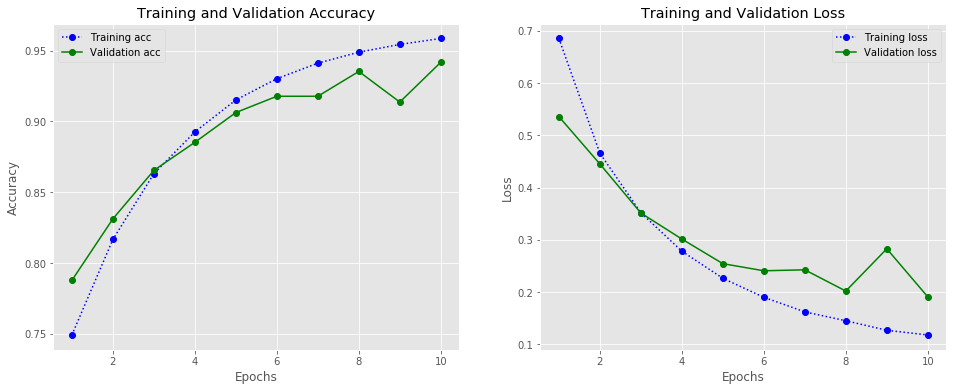

In [48]:
# VALIDATION ACCURACY and LOSS Curve
plot_validation_curve(history, ['acc','loss'])

In [49]:
loss, acc = model.evaluate([x_val, x_heading_val], y_val)
print('Accuracy:', np.round(acc * 100, decimals=2))

9994/9994 [==============================] - 18s 2ms/step
Accuracy: 94.18


In [50]:
# Analyze Classification Summary
y_proba = model.predict([x_val, x_heading_val])
y_pred = (y_proba > 0.5).astype('int32')
classification_summary(y_val, y_pred, y_proba)

Model accuracy: 93.81%
________________________________________________________________________________
Confusion matrix:
 [[ 591   49   29   70]
 [  51   95   10   18]
 [  76    3 1589  111]
 [  73   10   90 7129]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79       739
           1       0.61      0.55      0.57       174
           2       0.92      0.89      0.91      1779
           3       0.97      0.98      0.97      7302

   micro avg       0.95      0.94      0.94      9994
   macro avg       0.83      0.79      0.81      9994
weighted avg       0.95      0.94      0.94      9994
 samples avg       0.94      0.94      0.94      9994

________________________________________________________________________________


**Observations:**
- This network shows a very good accuracy with better reduction in loss compared to the first network.
- Also the graphs for accuracy and loss doesn't show any traces of overfitting, unlike the first network without Attention layer.

## Summary
RNNs cannot remember longer sentences and sequences due to the vanishing/exploding gradient problem. Although an LSTM is supposed to capture the long-range dependency better than the RNN, it tends to become forgetful in specific cases where the context is located a few words back rather than the ones it has just seen and remembered. Hence the performance of the encoder-decoder network degrades rapidly as the length of the input sentence increases.

So Attention mechanism comes in a rescue where not only can all the input words be taken into account in the context vector, but relative importance should also be given to each one of them. So, whenever the proposed model generates a sentence, it searches for a set of positions in the encoder hidden states where the most relevant information is available. This idea is called ‘Attention’ and it is proven to be performing better than simple encoder-decoder network for NLP tasks.